In [22]:
import numpy as np
import pandas as pd
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity.alpha import shannon
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
            'grid.color': 'black'
            }, 
       font_scale=2)

In [2]:
df = pd.read_csv('pnas.1502875112.sd01.csv', index_col=0)
md = pd.read_csv('pnas.1502875112.sd02.txt', sep='\t', index_col=0)
md=md.loc[ md.BodySite=='Vaginal_Swab' ]
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]
df = df.loc[:, df.sum(axis=0)> 0]

In [3]:
df.shape

(930, 723)

In [4]:
df['empty_feature'] = 0

In [5]:
md.PretermBirth.value_counts()

False    699
True     231
Name: PretermBirth, dtype: int64

In [6]:
sh_alphas = [shannon(x) for x in df.values]

In [7]:
len(sh_alphas)

930

In [8]:
df.shape

(930, 724)

In [9]:
pr = pearsonr(md.PretermBirth, sh_alphas)

In [10]:
mw = mannwhitneyu( np.array(sh_alphas)[md.PretermBirth], 
              np.array(sh_alphas)[md.PretermBirth==False]
            )

In [11]:
md.Gestational_status_at_collection.value_counts() ## keeping both, because why not

pregnant       767
post-partum    163
Name: Gestational_status_at_collection, dtype: int64

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


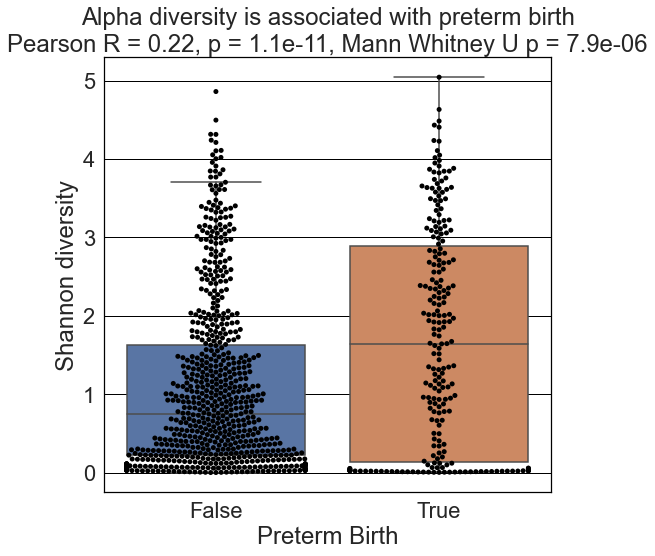

In [12]:
plt.figure(figsize=(8,8))
sns.boxplot(x = md.PretermBirth, 
            y=sh_alphas, 
            fliersize=0
           )


sns.swarmplot(x = md.PretermBirth, 
              y=sh_alphas, 
              size=5, 
              color='black'
              )
plt.ylabel('Shannon diversity')
plt.xlabel('Preterm Birth')
plt.title('Alpha diversity is associated with preterm birth\n'+\
          'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)+\
          'Mann Whitney U p = {:.1e}'.format(mw.pvalue)
          )
plt.show()

In [13]:
from debiasm.torch_functions import rescale

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
X_clr = clr(rescale(df.values) + 1e-5)

In [15]:
pearsonr(md.PretermBirth, X_clr[:, -1])

(-0.13423059240195942, 4.0156867394365785e-05)

In [16]:
mannwhitneyu(np.array(X_clr[:, -1])[md.PretermBirth], 
             np.array(X_clr[:, -1])[md.PretermBirth==False]
             )

MannwhitneyuResult(statistic=71398.0, pvalue=0.00417302242431202)

In [17]:
pr = pearsonr(md.PretermBirth, X_clr[:, -1])
mw = mannwhitneyu( np.array(X_clr[:, -1])[md.PretermBirth], 
              np.array(X_clr[:, -1])[md.PretermBirth==False]
            )

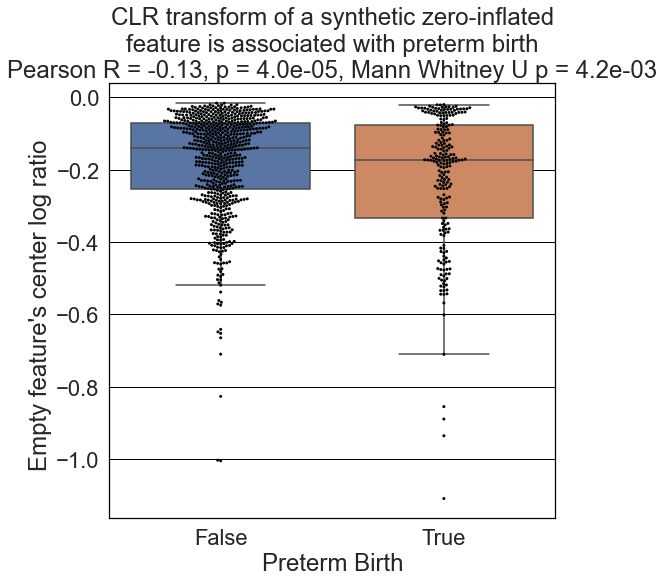

In [18]:
plt.figure(figsize=(8,8))
sns.boxplot(x = md.PretermBirth, 
            y=X_clr[:, -1], 
            fliersize=0
           )


sns.swarmplot(x = md.PretermBirth, 
              y=X_clr[:, -1], 
              size=3, 
              color='black'
              )
plt.ylabel("Empty feature's center log ratio ")
plt.xlabel('Preterm Birth')
plt.title('CLR transform of a synthetic zero-inflated\nfeature is associated with preterm birth\n'+\
          'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)+\
          'Mann Whitney U p = {:.1e}'.format(mw.pvalue)
          )
plt.show()


In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
pr = pearsonr(sh_alphas, X_clr[:, -1])

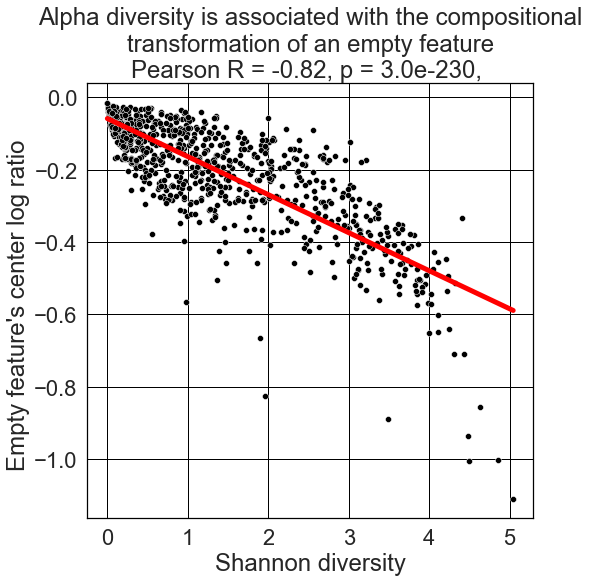

In [21]:
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x = sh_alphas, 
                y=X_clr[:, -1], 
                color='black',
#                 fliersize=0
               )


lr = LinearRegression()
sns.lineplot(x = sh_alphas, 
             y=lr.fit(np.array(sh_alphas)[:, np.newaxis], 
                                    X_clr[:, -1])\
                         .predict(np.array(sh_alphas)[:, np.newaxis]), 
             color='red',
             linewidth=5, 
             ax=ax
               )
plt.title('Alpha diversity is associated with the compositional\ntransformation of an empty feature\n'+\
          'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)
         )
plt.xlabel('Shannon diversity')
    
plt.ylabel("Empty feature's center log ratio ")
plt.show()
